In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [4]:
def match_SIFT(im1, im2, thres = 0.6):
    ''' Extract the coordinates of matching points using SIFT.'''    
    
    # Initiate SIFT detector
    sift = cv2.SIFT_create()
    
    # Find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(im1, None)
    kp2, des2 = sift.detectAndCompute(im2, None)
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test
    good_matches = []
    
    for m, n in matches:
        if m.distance/(n.distance+10e-10) < thres:
            good_matches.append([m])
    
    # Extract the coordinates
    pts_im1 = [kp1[m[0].queryIdx].pt for m in good_matches]
    pts_im1 = np.array(pts_im1, dtype=np.float32).T
    pts_im2 = [kp2[m[0].trainIdx].pt for m in good_matches]
    pts_im2 = np.array(pts_im2, dtype=np.float32).T
    return pts_im1, pts_im2

#### **Keypoints and descriptors**
- Keypoints are the interesting points in the image.
- Descriptors are the unique features extracted from those keypoints.

#### **bf = cv2.BFMatcher()**
- Initializes a brute-force matcher object for matching the descriptors between two images.

#### **matches = bf.knnMatch(des1, des2, k=2)**
- Finds the two nearest neighbors for each descriptor in des1 by comparing it to des2.
- The parameter k=2 means for each descriptor in des1, the two closest descriptors in des2 are found. These pairs are considered potential matches.

#### **Ratio test**
- Iterates through each pair of matches (m, n). A match m is considered good and added to good_matches if its distance is less than thres times the distance of the next best match n.
- Calculate the ratio of the distance of the best match to the distance of the second-best match.
  - If this ratio is below a certain threshold (e.g., 0.6), consider the best match as a good match. Otherwise, discard it.

#### **Extract the coordinates**
- Extracts the coordinates of keypoints in im1 and im2 that correspond to the good matches.

In [5]:
def plot_matching_keypoints(im1, im2, pts_im1, pts_im2):
    ''' Plot SIFT matches.'''    

    # Making mosaic image
    r1, c1 = im1.shape
    r2, c2 = im2.shape
    n_row = np.maximum(r1, r2)
    n_col = c1 + c2
    im_comp = np.zeros((n_row, n_col))
    im_comp[:r1, :c1] = im1
    im_comp[:r2, c1:(c1+c2)] = im2
    
    # Plot mosaic and matches
    fig, ax = plt.subplots(1,figsize=(10,8))
    ax.imshow(im_comp, cmap='gray')
    ax.plot([pts_im1[0], pts_im2[0] + c1], 
            [pts_im1[1], pts_im2[1]], 'w', linewidth = 0.5)
    ax.plot(pts_im1[0], pts_im1[1], '.r')
    ax.plot(pts_im2[0] + c1, pts_im2[1],' .b')

In [6]:
def get_transformation(p, q):
    '''
    Compute the transformation parameters of hte equation:
        q = s*R@p + t

    Parameters
    ----------
    p : numpy array
        2 x n array of points.
    q : numpy array
        2 x n array of points. p and q corresponds.

    Returns
    -------
    R : numpy array
        2 x 2 rotation matrix.
    t : numpy array
        2 x 1 translation matrix.
    s : float
        scale parameter.

    '''

    # Calculate the centroids
    m_p = np.mean(p, axis=1, keepdims=True)
    m_q = np.mean(q, axis=1, keepdims=True)

    # Calculate the scale, rotation and translation
    s = np.linalg.norm(q - m_q)/np.linalg.norm(p - m_p)
    
    # Compute the covariance matrix
    C = (q - m_q) @ (p - m_p).T

    # Singular value decomposition
    U, S, Vt = np.linalg.svd(C)
    
    # Initial rotation matrix
    R_ = U @ Vt

    # Adjusting for reflection
    R = R_ @ np.array([[1, 0], [0, np.linalg.det(R_)]])
    
    # Translation
    t = m_q - s * R@m_p
    return R, t, s

#### **Calculate the centroids**
- Computes the centroids (m_p and m_q) of the point sets p and q by taking the mean along each dimension.

#### **Scale calculation**
- Calculates the scale factor s needed to adjust the size of p to match q. It does this by dividing the norm (size) of the shifted q points by the norm of the shifted p points.

#### **Covariance matrix**
- Constructs a covariance matrix C from the centered points. This matrix captures the correlation between the p and q points necessary for determining the rotation.

#### **Singular value decomposition**
- Performs SVD on the covariance matrix C.

#### **Adjustin for reflection**
- This adjustment is crucial for ensuring that the transformation applied to the points (or images) correctly aligns them without altering their intrinsic properties through flipping.
- The determinant of a proper rotation matrix should be +1. A determinant of -1 indicates that the matrix includes a reflection. The code checks the determinant of the initial rotation matrix R_ (which is the product of U and Vt from the SVD of the covariance matrix C).

# Apply to images

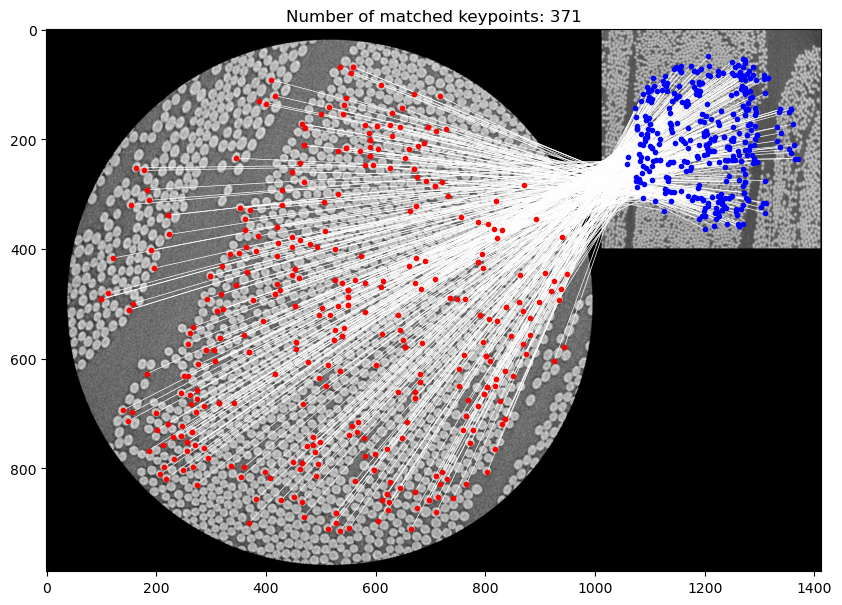

In [7]:
path = '../week3/data/' # Replace with your own path

im1 = cv2.imread(path + 'quiz_image_1.png', cv2.IMREAD_GRAYSCALE)
im2 = cv2.imread(path + 'quiz_image_2.png', cv2.IMREAD_GRAYSCALE)

pts_im1, pts_im2 = match_SIFT(im1, im2, 0.5)
plot_matching_keypoints(im1, im2, pts_im1, pts_im2)
plt.title(f'Number of matched keypoints: {pts_im1.shape[1]}')
plt.show()

In [8]:
R, t, s = get_transformation(pts_im1, pts_im2)
print(f'Scale: {s:.2g}')
print(f'Translation length: {np.linalg.norm(t):.2f}')

Scale: 0.37
Translation length: 539.78
